In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, datetime

from multiprocessing import Pool, cpu_count

from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import PredefinedSplit, cross_val_score
from sklearn.grid_search import GridSearchCV
from scipy.stats import linregress

import ml_metrics as metrics

%matplotlib inline

dataurl = '/home/dbricare/Documents/Python/datasets/bimbo/'

# Load and examine train and test data

In [2]:
dataurl = '/home/dbricare/Documents/Python/datasets/bimbo/'

def inspectdata(testortrain, cols=None, rows=None):
    dataparams = {'sep':',', 'compression':'zip', 'usecols':cols, 'nrows':rows}
    df = pd.read_csv(dataurl+testortrain+'.csv.zip', **dataparams)
    print(df.shape)
    dictcols = dict(zip(list(df.columns),[df[col].dtype for col in df.columns]))
    print(dictcols)
    return df

In [3]:
dftrain = inspectdata('train')
dftrain.head()

(74180464, 11)
{'Venta_hoy': dtype('float64'), 'Cliente_ID': dtype('int64'), 'Demanda_uni_equil': dtype('int64'), 'Venta_uni_hoy': dtype('int64'), 'Dev_uni_proxima': dtype('int64'), 'Agencia_ID': dtype('int64'), 'Canal_ID': dtype('int64'), 'Semana': dtype('int64'), 'Ruta_SAK': dtype('int64'), 'Dev_proxima': dtype('float64'), 'Producto_ID': dtype('int64')}


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


In [4]:
dftest = inspectdata('test')
dftest.head()

(6999251, 7)
{'Cliente_ID': dtype('int64'), 'Ruta_SAK': dtype('int64'), 'Semana': dtype('int64'), 'Producto_ID': dtype('int64'), 'id': dtype('int64'), 'Agencia_ID': dtype('int64'), 'Canal_ID': dtype('int64')}


,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277


___
# Establish naming scheme for clients

Data description explains there are multiple client names for each client ID.

In [42]:
dfclient = inspectdata('cliente_tabla')
print(dfclient['Cliente_ID'].max())   # do row number and Cliente_ID match?
dfclient.head(10)

(935362, 2)
{'NombreCliente': dtype('O'), 'Cliente_ID': dtype('int64')}
2015152015


,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT
5,4,SDN SER DE ALIM CUERPO SA CIA DE INT
6,5,LA VAQUITA
7,6,LUPITA
8,7,I M EL GUERO
9,8,MINI SUPER LOS LUPES


In [43]:
# appears to be some duplicates which can be dropped, Cliente_ID not in tabla will be assumed 'SIN NOMBRE'

# make cases match before comparison
dfclient['NombreCliente'] = dfclient['NombreCliente'].str.upper()
dfclient['nc'] = dfclient['NombreCliente'].str.replace(' ','')

dfclient.drop_duplicates('nc', inplace=True)
print(dfclient.shape)
# print(dfclient['Cliente_ID'].max())
# print(dfclient['NombreCliente'].loc[4],dfclient['NombreCliente'].loc[5])
dfclient.head(10)

(304876, 3)


,Cliente_ID,NombreCliente,nc
0,0,SIN NOMBRE,SINNOMBRE
1,1,OXXO XINANTECATL,OXXOXINANTECATL
3,3,EL MORENO,ELMORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,SDNSERDEALIMCUERPOSACIADEINT
6,5,LA VAQUITA,LAVAQUITA
7,6,LUPITA,LUPITA
8,7,I M EL GUERO,IMELGUERO
9,8,MINI SUPER LOS LUPES,MINISUPERLOSLUPES
10,9,SUPER KOMPRAS MICRO COLON,SUPERKOMPRASMICROCOLON
11,10,LONJA MERCANTIL DE TODO,LONJAMERCANTILDETODO


In [44]:
# drop unnecessary column 'nc', drop row for 'SIN NOMBRE', create 'present' column and save new table

dfclient.drop(0, axis=0, inplace=True)
dfclient['present'] = 1
dfclient[['Cliente_ID', 'NombreCliente', 'present']].to_csv(dataurl+'cliente_tabla_drop.csv', sep=',', index=False)

In [45]:
dfclient.head()

,Cliente_ID,NombreCliente,nc,present
1,1,OXXO XINANTECATL,OXXOXINANTECATL,1
3,3,EL MORENO,ELMORENO,1
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT,SDNSERDEALIMCUERPOSACIADEINT,1
6,5,LA VAQUITA,LAVAQUITA,1
7,6,LUPITA,LUPITA,1


In [47]:
clientgroup = dfclient.groupby('Cliente_ID').count()
clientgroup['NombreCliente'].describe()

count    304875.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: NombreCliente, dtype: float64

## Result

Client names are cleaned up by removing spaces and droping duplicates. Each `Cliente_ID` now maps to a single `NombreCliente`.

Initial model will only take into account if name is present in table (categorical Bernoulli variables). Future models may (1) count the number of words in the name, (2) look for clients who are individuals, government or businesses, (3) differentiate types of businesses (large vs small stores, etc.)

___
# Establish sales volume for each client

There may be a link between product demand and size of bimbo product portfolio for store/client.

In [36]:
# To speed up analysis, look at only semana 3

# df3 = dftrain[dftrain['Semana']==3].copy()
# df3.drop('Semana', axis=1, inplace=True)

# clienteruta = df3[['Cliente_ID', 'Ruta_SAK']].groupby('Cliente_ID').count()

In [53]:
# Groupby client and unique products

clientprod = dftrain[['Cliente_ID', 'Producto_ID']].groupby('Cliente_ID').Producto_ID.nunique()

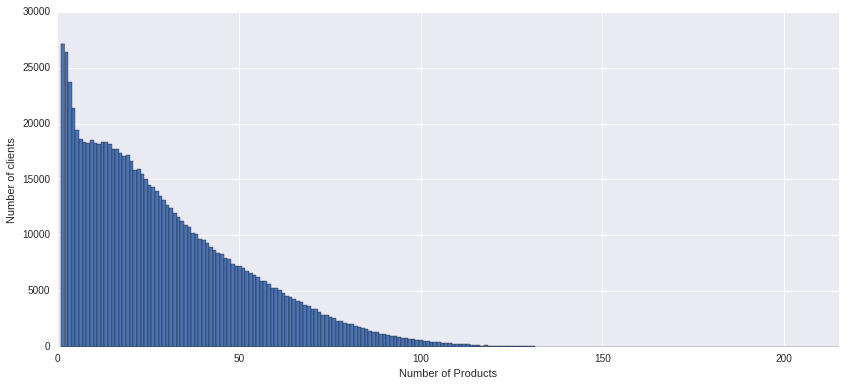

In [73]:
_ = plt.figure(figsize=(14,6))
_ = plt.xlabel('Number of Products')
_ = plt.ylabel('Number of clients')
_ = plt.xlim(0,215)

_ = clientprod.hist(bins=215)

In [62]:
clientprod.describe()

count    880604.000000
mean         29.333887
std          23.040138
min           1.000000
25%          11.000000
50%          24.000000
75%          43.000000
max         215.000000
Name: Producto_ID, dtype: float64

In [60]:
dfcp = clientprod.reset_index()
dfcp.head()

,Cliente_ID,Producto_ID
0,26,51
1,60,34
2,65,112
3,101,4
4,105,72


In [61]:
# expect each client in training data to have an entry in this dataframe

print(len(dftrain['Cliente_ID'].unique()),dfcp.shape[0])

880604 880604


In [71]:
# save data for future use
dfcp.sort_values('Producto_ID', axis=0, ascending=False, inplace=True)
dfcp.columns = ['Cliente_ID', 'prodcount']
dfcp.to_csv(dataurl+'producto_por_cliente.csv', sep=',', index=False)

## Result

Created table to construct feature consisting of number of product types delivered per client.

___
# Examine product information

In [19]:
dfprod = inspectdata('producto_tabla')
dfprod.head()

(2592, 2)
{'Producto_ID': dtype('int64'), 'NombreProducto': dtype('O')}


,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
3,53,Burritos Sincro 170g CU LON 53
4,72,Div Tira Mini Doradita 4p 45g TR 72


**Factors to consider**: product type (shelf life), product size, manufacturer.

In [6]:
# check for duplicates
len(dfprod.drop_duplicates('NombreProducto'))

2592

In [20]:
dfprod.drop(0, axis=0, inplace=True)
print(dfprod.loc[218])
dfprod.head(10)

Producto_ID                              4118
NombreProducto    Tortillas Bolsa 2a 1kg 4118
Name: 218, dtype: object


,Producto_ID,NombreProducto
1,9,Capuccino Moka 750g NES 9
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
3,53,Burritos Sincro 170g CU LON 53
4,72,Div Tira Mini Doradita 4p 45g TR 72
5,73,Pan Multigrano Linaza 540g BIM 73
6,98,Tostado Integral 180g WON 98
7,99,Pan Blanco 567g WON 99
8,100,Super Pan Bco Ajonjoli 680g SP WON 100
9,106,Wonder 100pct mediano 475g WON 106
10,107,Wonder 100pct gde 680g SP WON 107


In [58]:
# each product seems to have a name, quantity and the product ID repeated at the end of the string
# (\w+\s+)*(\d+[Kk]*[PpGg]*[ml]*\s+)*(\d+[Kk]*[PpGg]*[ml]*\s+)*

dfprod['NombreProducto'] = dfprod['NombreProducto'].str.strip()
dfprod['NombreProducto'] = dfprod['NombreProducto'].str.replace('\s*\d+$', '')

# fix entries with errors
dfprod.set_value(218,'NombreProducto', 'Tortillas Bolsa 2a 1kg BIM')
dfprod.set_value(1152, 'NombreProducto', 'Burrito Vaporero FrijolChorizo 90g CU LON')
dfprod.set_value(1336, 'NombreProducto', 'DuoBarrita Fsa GalletaGansito 137g MTA MLA')
dfprod['NombreProducto'] = dfprod['NombreProducto'].str.replace('(?<=\d)G\s', 'g ')
dfprod['NombreProducto']= dfprod['NombreProducto'].str.replace('Kg', 'k')
dfprod['NombreProducto']= dfprod['NombreProducto'].str.replace('\sml', 'ml')

dfprod['man'] = dfprod['NombreProducto'].str.extract('([A-Z]+)$', expand=False)
dfprod['amt'] = dfprod['NombreProducto'].str.extract('(\d*\s*\d+[gkm])', expand=False)
dfprod['cnt'] = dfprod['NombreProducto'].str.extract('(\d+[pP]\s+)', expand=False)

# clean up name by dropping suffix
# dfprod['name'] = dfprod['NombreProducto'].str.replace('\w+$', '')
dfprod['name'] = dfprod['NombreProducto'].str.strip()
dfprod['name'] = dfprod['name'].str.replace('\d+p(?![a-z])|\d{2,3}\w{1,2}(?![a-z])|[A-Z]{2,3}','')
# dfprod['name'] = dfprod['name'].str.replace('\d+\s*[KkGgmM]$', '')


dfprod.head(10)

,Producto_ID,NombreProducto,man,amt,cnt,name,unit,multiplier,size
1,9,Capuccino Moka 750g NES,NES,750g,NaN,Capuccino Moka,g,1.0,750.0
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM,BIM,480g,6p,Bimbollos Ext sAjonjoli,g,6.0,2880.0
3,53,Burritos Sincro 170g CU LON,LON,170g,NaN,Burritos Sincro,g,1.0,170.0
4,72,Div Tira Mini Doradita 4p 45g TR,TR,45g,4p,Div Tira Mini Doradita,g,4.0,180.0
5,73,Pan Multigrano Linaza 540g BIM,BIM,540g,NaN,Pan Multigrano Linaza,g,1.0,540.0
6,98,Tostado Integral 180g WON,WON,180g,NaN,Tostado Integral,g,1.0,180.0
7,99,Pan Blanco 567g WON,WON,567g,NaN,Pan Blanco,g,1.0,567.0
8,100,Super Pan Bco Ajonjoli 680g SP WON,WON,680g,NaN,Super Pan Bco Ajonjoli,g,1.0,680.0
9,106,Wonder 100pct mediano 475g WON,WON,475g,NaN,Wonder 100pct mediano,g,1.0,475.0
10,107,Wonder 100pct gde 680g SP WON,WON,680g,NaN,Wonder 100pct gde,g,1.0,680.0


In [59]:
print(dfprod[dfprod[['amt', 'cnt']].isnull().all(axis=1)].shape)
dfprod[dfprod[['amt', 'cnt']].isnull().all(axis=1)]

(27, 9)


,Producto_ID,NombreProducto,man,amt,cnt,name,unit,multiplier,size
190,3509,Paletina para Cafe NES,NES,NaN,NaN,Paletina para Cafe,1,NaN,2247.769465
381,30099,Camioncitos Bimbo BIM,BIM,NaN,NaN,Camioncitos Bimbo,1,NaN,2247.769465
409,30280,Camioncito Bimbo Modelo 3 BIM,BIM,NaN,NaN,Camioncito Bimbo Modelo 3,1,NaN,2247.769465
528,30958,Empanzador Crujiente Prom BIM,BIM,NaN,NaN,Empanzador Crujiente Prom,1,NaN,2247.769465
1044,33862,Choco Roles Fresa 3X10 Prom MLA,MLA,NaN,NaN,Choco Roles Fresa 3X10 Prom,1,NaN,2247.769465
1045,33863,Choco Roles Fresa 3X10 Prom MTB MLA,MLA,NaN,NaN,Choco Roles Fresa 3X10 Prom,1,NaN,2247.769465
1389,35618,Exhibidor PDQ Bran Frut BIM,BIM,NaN,NaN,Exhibidor Bran Frut,1,NaN,2247.769465
1485,35979,Almohada del Osito Bimbo BIM,BIM,NaN,NaN,Almohada del Osito Bimbo,1,NaN,2247.769465
1526,36141,Pan Blanco Freihofers 28Reb MTA BIM,BIM,NaN,NaN,Pan Blanco Freihofers 28Reb,1,NaN,2247.769465
1527,36143,Pan Blanco Freihofers 28Reb TNB BIM,BIM,NaN,NaN,Pan Blanco Freihofers 28Reb,1,NaN,2247.769465


In [60]:
dfprod['man'].unique()

array(['NES', 'BIM', 'LON', 'TR', 'WON', 'DH', 'SUA', 'SL', 'LAR', 'MLA',
       'MR', 'ORO', 'VR', 'SUN', 'BAR', 'COR', 'CC', 'RIC', 'CHK', 'MP',
       'GBI', 'KOD', 'MSK', 'SAN', 'THO', 'DIF', 'SKD', 'LC', 'VER', 'PUL',
       'AV', 'GV', 'TRI', 'NAI', 'MCM', 'EMB', 'CAR', 'BRL', 'JMX', 'BRE',
       'AM', 'NEC', 'MTB'], dtype=object)

In [61]:
dfprod['amt'] = dfprod['amt'].str.strip()
dfprod['unit'] = dfprod['amt'].str.extract('(\w)$', expand=False)
print(dfprod['unit'].unique())
dfprod['amt'] = dfprod['amt'].str.replace('\w$', '')
dfprod['amt'] = dfprod['amt'].str.replace(' ','.')
# dfprod['amt'].fillna()
print(dfprod['amt'].unique())

['g' 'k' nan 'm']
['750' '480' '170' '45' '540' '180' '567' '680' '475' '280' '410' '450'
 '1635' '1730' '290' '435' '470' '1950' '1237' '25' '5' '200' '260' '976'
 '1000' '1080' '500' '55' '50' '76' nan '114' '30' '900' '248' '250' '210'
 '1200' '345' '175' '2.4' '360' '80' '365' '255' '1360' '740' '510' '840'
 '350' '675' '230' '340' '1.31' '1700' '72' '420' '120' '135' '130' '140'
 '125' '105' '62' '236' '66' '65' '454' '960' '650' '1440' '600' '40' '520'
 '550' '1.05' '460' '70' '75' '77' '530' '64' '640' '58' '62.5' '67'
 '226.8' '44' '89' '525' '700' '85' '74' '88' '150' '300' '2' '560' '6'
 '115' '95' '100' '370' '32' '240' '86' '69' '497' '157' '1' '585' '60'
 '110' '220' '489' '660' '354' '355' '192' '225' '193' '90' '205' '234.5'
 '522' '720' '610' '804' '768' '191' '186' '197' '208' '54' '36' '49'
 '1.70' '52' '20' '425' '570' '42.5' '35' '1775' '10' '1470' '124' '56'
 '104' '48' '113' '310' '270' '31' '506' '1020' '22' '132' '106' '84' '112'
 '400' '430' '152' '224' '34' '3

In [62]:
dfprod['cnt'] = dfprod['cnt'].str.strip().str.lower()
dfprod['cnt'] = dfprod['cnt'].str.replace('p','')
dfprod['cnt'].unique()

array([nan, '6', '4', '8', '36', '30', '20', '24', '15', '10', '12', '18',
       '1', '2', '3', '200', '22', '16', '50', '26', '5', '40', '14', '27',
       '7', '33', '48', '11', '43', '45', '21', '19', '9', '32', '104',
       '100', '25'], dtype=object)

In [63]:
dfprod['unit'].unique()

array(['g', 'k', nan, 'm'], dtype=object)

In [27]:
# check if number at end of product name string can be dropped
# assert(all([a==b for a,b in zip(dfprod['Producto_ID'].tolist(),dfprodnew[2].astype(int).tolist())]))

In [64]:
# calculate size of each product taking into account the unit of measure and package count
# replace unknown values with mean(this will reduce some of the variability but only 1% of the product sizes missing)

dfprod.fillna('1', inplace=True)
dfprod['cnt'] = dfprod['cnt'].astype(int)
unitconv = {'g':1, 'k':1000, 'm':1}
dfprod['multiplier'] = dfprod['unit'].apply(lambda x: unitconv.get(x,np.nan)) * dfprod['cnt']
dfprod['size'] = dfprod['amt'].astype(float) * dfprod['multiplier']
dfprod['size'].fillna(dfprod['size'].mean(), inplace=True)

In [65]:
dfprod.head(10)

,Producto_ID,NombreProducto,man,amt,cnt,name,unit,multiplier,size
1,9,Capuccino Moka 750g NES,NES,750,1,Capuccino Moka,g,1.0,750.0
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM,BIM,480,6,Bimbollos Ext sAjonjoli,g,6.0,2880.0
3,53,Burritos Sincro 170g CU LON,LON,170,1,Burritos Sincro,g,1.0,170.0
4,72,Div Tira Mini Doradita 4p 45g TR,TR,45,4,Div Tira Mini Doradita,g,4.0,180.0
5,73,Pan Multigrano Linaza 540g BIM,BIM,540,1,Pan Multigrano Linaza,g,1.0,540.0
6,98,Tostado Integral 180g WON,WON,180,1,Tostado Integral,g,1.0,180.0
7,99,Pan Blanco 567g WON,WON,567,1,Pan Blanco,g,1.0,567.0
8,100,Super Pan Bco Ajonjoli 680g SP WON,WON,680,1,Super Pan Bco Ajonjoli,g,1.0,680.0
9,106,Wonder 100pct mediano 475g WON,WON,475,1,Wonder 100pct mediano,g,1.0,475.0
10,107,Wonder 100pct gde 680g SP WON,WON,680,1,Wonder 100pct gde,g,1.0,680.0


In [66]:
dfprod[['Producto_ID','name','man','size']].to_csv(dataurl+'producto_conv_tabla.csv', sep=',', index=False)

In [36]:
# save manufacturer category dictionary as csv

dfprod = pd.read_csv(dataurl+'producto_conv_tabla.csv', sep=',', usecols=['Producto_ID', 'man'])
mandict = dict(zip(dfprod['man'].unique().tolist(), list(range(len(dfprod['man'].unique())))))
dfprod['man'] = dfprod['man'].apply(lambda x: mandict[x])
dfprod.to_csv(dataurl+'mandict.csv', sep=',', index=False)

### Result

Created table to look up product manufacturer and size based on product id.

___
# Identify linear trends in demand

Compute linear trendline for demanda as a function of semana for each pair of producto and cliente IDs.

In [4]:
# select only relevant data

dflr = inspectdata('train', cols=['Producto_ID','Cliente_ID', 'Semana', 'Demanda_uni_equil'])
# dflr = dftrain[].sort_values(['Producto_ID', 'Cliente_ID'], inplace=False)
# .set_index(['Producto_ID', 'Cliente_ID'])
dflr.head()

(74180464, 4)
{'Producto_ID': dtype('int64'), 'Demanda_uni_equil': dtype('int64'), 'Cliente_ID': dtype('int64'), 'Semana': dtype('int64')}


,Semana,Cliente_ID,Producto_ID,Demanda_uni_equil
0,3,15766,1212,3
1,3,15766,1216,4
2,3,15766,1238,4
3,3,15766,1240,4
4,3,15766,1242,3


In [27]:
# trend in overall product demand?

dfsemgroup = dflr.groupby('Semana').Demanda_uni_equil.sum()
dfsemgroup = dfsemgroup/dfsemgroup.sum()

LinregressResult(slope=-408.24416328873531, intercept=64.320594755533619, rvalue=-0.68068614704252073, pvalue=0.092333150556350274, stderr=196.48991295959664)


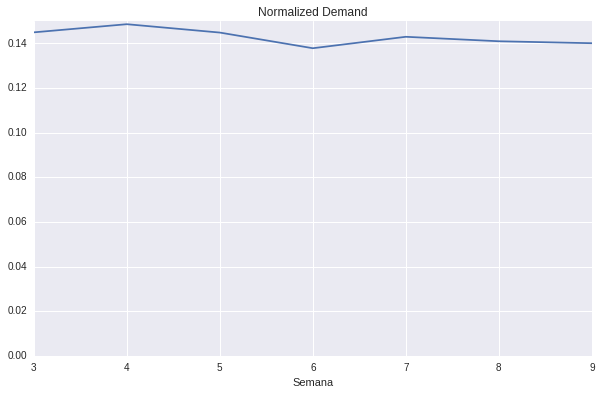

In [41]:
print(linregress(dfsemgroup.values.reshape(1,-1)[0], dfsemgroup.index.values.reshape(1,-1)[0]))
_ = dfsemgroup.plot(figsize=(10,6))
_ = plt.title('Normalized Demand')
_ = plt.ylim(0,0.15)

In [42]:
# create function to aggregate groups, use multiprocessing for speed

def lrparams(tup):
    x = tup[1]['Semana']
    y = tup[1]['Demanda_uni_equil']
    # some product-client pairs only have a single datapoint so linregress not possible
    # so set equal to average over period (no independent variable)
    if len(x)<2:
        lr = (0, y.values[0]/9) # 7 instead?
    else:
        lr = linregress(x.values, y.values)
        return pd.DataFrame({'0':[tup[0][0]], '1':[tup[0][1]], '2':[lr[0]], '3':[lr[1]]})

def applyParallel(dfGrouped, func):
    with Pool(cpu_count()) as p:
        # ret_list = p.map(func, [group for name, group in dfGrouped])
        ret_list = p.map(func, list(dfGrouped))
    df = pd.concat(ret_list, ignore_index=True)
    df.columns = ['Producto_ID', 'Cliente_ID', 'slope', 'intercept']
    return df

# will need to breakup dataframe to process in-memory

def chunkApply(dflr, col, groupcols, func):
    percents = np.arange(0,100,5)
    vals = [dflr[col].max()+1]
    for p in percents:
        vals.append(int(np.percentile(dflr[col],p)))
    vals.sort()
    # vals = [dflr[col].min(), dflr[col].min()+1]
    print('Chunk indices:', vals) 
    
    for i in range(1,len(vals)):   
        # select portion
        dflrpart = dflr[(dflr[col]>=vals[i-1]) & (dflr[col]<vals[i])]
        print('Part {:0} of {:1}'.format(i,len(vals)-1))
        print('Row count:', '{:,}'.format(len(dflrpart)))
        # group dataframe by product and client ID
        dfgrouplr = dflrpart.groupby(groupcols)

        chunk = applyParallel(dfgrouplr, func)
        dflrpart = None
        dfgrouplr = None
        # overwrite existing file on first pass, otherwise append to file
        if i==1:
            writemode = 'w'
            writehead = True
        else:
            writemode = 'a'
            writehead = False

        chunk.to_csv(dataurl+'chunks.csv', sep=',', index=False, header=writehead, mode=writemode)
        chunk = None

    return # chunk

In [43]:
chunkApply(dflr, 'Producto_ID', ['Producto_ID', 'Cliente_ID'], lrparams)

Chunk indices: [41, 1109, 1150, 1216, 1238, 1242, 1278, 1309, 2425, 4767, 30549, 31423, 32861, 35141, 35727, 37426, 43039, 43069, 43206, 43316, 49998]
Part 1 of 20
Row count: 2,363,210
Part 2 of 20
Row count: 4,736,851
Part 3 of 20
Row count: 3,525,571
Part 4 of 20
Row count: 4,103,428
Part 5 of 20
Row count: 3,338,528
Part 6 of 20
Row count: 3,977,807
Part 7 of 20
Row count: 3,068,286
Part 8 of 20
Row count: 3,641,619
Part 9 of 20
Row count: 4,541,351
Part 10 of 20
Row count: 3,779,316
Part 11 of 20
Row count: 3,496,073
Part 12 of 20
Row count: 3,888,582
Part 13 of 20
Row count: 3,731,025
Part 14 of 20
Row count: 3,724,220
Part 15 of 20
Row count: 3,718,840
Part 16 of 20
Row count: 3,648,070
Part 17 of 20
Row count: 2,775,631
Part 18 of 20
Row count: 4,510,171
Part 19 of 20
Row count: 3,768,787
Part 20 of 20
Row count: 3,843,098


In [43]:
# inconsistent entries in database
# do semanas without an entry correspond to 0 demanda? or is demanda the same as other semanas?

dflr[dflr['Producto_ID']==41].sort_values(['Producto_ID','Cliente_ID'])

,Semana,Cliente_ID,Producto_ID,Demanda_uni_equil
41695158,6,146030,41,70
52092608,7,146030,41,60
62493243,8,146030,41,40
72914594,9,146030,41,65
41695437,6,465617,41,0
62493519,8,465617,41,0
9844030,3,681747,41,2064
20816872,4,681747,41,1430
31480206,5,681747,41,1686
41695443,6,681747,41,1250


In [5]:
# combine linreg parameters with product and client ID

dfprodclient = dflr[['Producto_ID','Cliente_ID', 'Demanda_uni_equil']].groupby(
    ['Producto_ID','Cliente_ID'], sort=True).count()
print(len(dfprodclient))
dfprodclient.head(10)

25831538


Demanda_uni_equil
Producto_ID Cliente_ID                   
41          146030                      4
            465617                      2
            681747                      7
            684023                      7
            685079                      2
            1035265                     1
            1105804                     1
            1451516                     1
            1546790                     5
            1623763                     7

In [11]:
# test speed of aggregating function with and without multiprocessing

dfgrouplr = dflrpart.groupby(['Producto_ID','Cliente_ID'])
% timeit -r1 -n1 applyParallel(dfgrouplr, lrparams)

dfgrouplr = dflrpart.groupby(['Producto_ID','Cliente_ID'])
% timeit -r1 -n1 dfgrouplr.apply(lrparams)

1 loop, best of 1: 47.1 s per loop
1 loop, best of 1: 1min 40s per loop


___
# Develop feature for store location

In [27]:
dfloc = inspectdata('town_state')
dfloc.head()

(790, 3)
{'Town': dtype('O'), 'Agencia_ID': dtype('int64'), 'State': dtype('O')}


,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


In [31]:
statedict = dict(zip(dfloc['State'].unique().tolist(), list(range(len(dfloc['State'].unique().tolist())))))
dfloc['stateid'] = dfloc['State'].apply(lambda x: statedict[x])
dfloc['stateid'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [53]:
# are all agency ids included in training data? True if len==0

dftrainmerg = pd.merge(dftrain, dfloc[['Agencia_ID','State']], how='left', on='Agencia_ID')
print(len(dftrainmerg[dftrainmerg['State'].isnull()]))

0


In [32]:
# save to csv

dfloc[['Agencia_ID', 'stateid']].to_csv(dataurl+'statedict.csv', sep=',', index=False)

### Result

Will left join training and test data with this table to generate province for each agency.

___
# Final features to use in first attempt model

**Product-based:**
1. Manufacturer (categorical)
1. Size of product (count and weight) (continuous)

**Client-based:**
1. Does the client have a name in database (bernoulli)
1. Number of bimbo products client sells (continuous)

**Sales depot-based:**
1. Province (categorical)

**Product and client:**
1. Linear trendline of demand over 9 weeks (slope and intercept) (continuous)

### Procedure

1. Left-join on `Agencia_ID` with `dfloc` fill `NaN` with `0`
1. Left-join on `Producto_ID` with `producto_conv_tabla.csv` fill with mean average
1. Left-join on `Cliente_ID` with `cliente_tabla_drop.csv` should be no missing data
1. Left-join on `Cliente_ID` with `producto_por_cliente.csv` should be no missing data
1. Left-join on `[Producto_ID, Cliente_ID]` with `linregress#.csv` fill with trendline calculated from weekly means
1. Drop primary keys `[Agencia_ID, Producto_ID, Cliente_ID]`
1. Clear memory
1. Save training data as csv

In [3]:
# load training data
df = inspectdata('train', cols=['Semana', 'Agencia_ID', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil'])

# compute mean average of demand each week and return the slope and intercept
# to fillna values
dfgroupsem = df[['Semana','Demanda_uni_equil']].groupby('Semana').mean()
semmean = linregress(dfgroupsem.values.reshape(1,-1)[0], dfgroupsem.index.values.reshape(1,-1)[0])
print(semmean)

(74180464, 5)
{'Semana': dtype('int64'), 'Agencia_ID': dtype('int64'), 'Producto_ID': dtype('int64'), 'Cliente_ID': dtype('int64'), 'Demanda_uni_equil': dtype('int64')}
LinregressResult(slope=8.4185166918455607, intercept=-54.842029041180105, rvalue=0.51480990366722712, pvalue=0.23708316101578414, stderr=6.2695838314307233)


In [4]:
def valuecountrep(dftrain, col):
    # replace col with ranked list of valuecounts
    ser = dftrain[col].value_counts()
    rankweight = list(range(len(ser)))[::-1]
    serrank = pd.Series(rankweight)
    return pd.DataFrame({col:ser.index, col+'weight':serrank})

In [5]:
def featurebuild(dftrain):

    dfloc = pd.read_csv(dataurl+'statedict.csv', sep=',')
    dftrain = pd.merge(dftrain, dfloc, how='left', on='Agencia_ID')
    dftrain['stateid'] = dftrain['stateid'].astype(int)
    dfstate = valuecountrep(dftrain, 'stateid')
    dftrain = pd.merge(dftrain, dfstate, how='left', on='stateid')
    dftrain.drop(['Agencia_ID','stateid'], axis=1, inplace=True)
    dfloc = None
    dfstate = None

    dfprod = pd.read_csv(dataurl+'mandict.csv', sep=',')
    dftrain = pd.merge(dftrain, dfprod, how='left', on='Producto_ID')
    dftrain['man'].fillna(dfprod['man'].value_counts().max(), inplace=True)
    dftrain['man'] = dftrain['man'].astype(int)
    dfman = valuecountrep(dftrain, 'man')
    dftrain = pd.merge(dftrain, dfman, how='left', on='man')
    dftrain.drop('man', axis=1, inplace=True)
    # dftrain['size'].fillna(dfprod['size'].mean(), inplace=True)
    dfprod = None
    dfman = None
    
    dfnamed = pd.read_csv(dataurl+'cliente_tabla_drop.csv', sep=',', usecols=['Cliente_ID', 'present'])
    dftrain = pd.merge(dftrain, dfnamed, how='left', on='Cliente_ID')
    dftrain['present'].fillna(0, inplace=True)
    dftrain['present'] = dftrain['present'].astype(int)
    dfnamed = None
    
    dfprodclient = pd.read_csv(dataurl+'producto_por_cliente.csv', sep=',')
    dftrain = pd.merge(dftrain, dfprodclient, how='left', on='Cliente_ID')
    dfprodclient = None
    
    dflr = pd.read_csv(dataurl+'linregress2.csv', sep=',')
    dftrain = pd.merge(dftrain, dflr, how='left', on=['Producto_ID','Cliente_ID'])
    dflr = None
    dftrain['slope'].fillna(semmean[0], inplace=True)
    dftrain['intercept'].fillna(semmean[1], inplace=True)
    dftrain['lr'] = dftrain['slope'] * dftrain['Semana'] + dftrain['intercept']
    dftrain['lr'] = dftrain['lr'].apply(lambda x: max(x,0))
    dftrain.drop(['Producto_ID', 'Cliente_ID', 'slope', 'intercept'], axis=1, inplace=True)
    
    return dftrain

In [6]:
dftrain = featurebuild(df)
print(dftrain.shape[0])
dftrain.head()

74180464


,Semana,Demanda_uni_equil,stateidweight,manweight,present,prodcount,lr
0,3,3,31,29,1,43,4.194030
1,3,4,31,29,1,43,2.619048
2,3,4,31,29,1,43,2.964286
3,3,4,31,29,1,43,6.104478
4,3,3,31,29,1,43,3.214286


In [12]:
corr = dftrain.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
corr

,Semana,Demanda_uni_equil,stateidweight,manweight,present,prodcount,lr
Semana,1.000000,0.003000,0.002240,0.000059,-0.002323,0.002334,0.049401
Demanda_uni_equil,0.003000,1.000000,-0.005986,-0.085570,0.082186,0.144274,0.909651
stateidweight,0.002240,-0.005986,1.000000,-0.029862,-0.003094,0.140307,-0.006743
manweight,0.000059,-0.085570,-0.029862,1.000000,-0.021735,-0.164273,-0.094579
present,-0.002323,0.082186,-0.003094,-0.021735,1.000000,0.071347,0.085083
prodcount,0.002334,0.144274,0.140307,-0.164273,0.071347,1.000000,0.149174
lr,0.049401,0.909651,-0.006743,-0.094579,0.085083,0.149174,1.000000


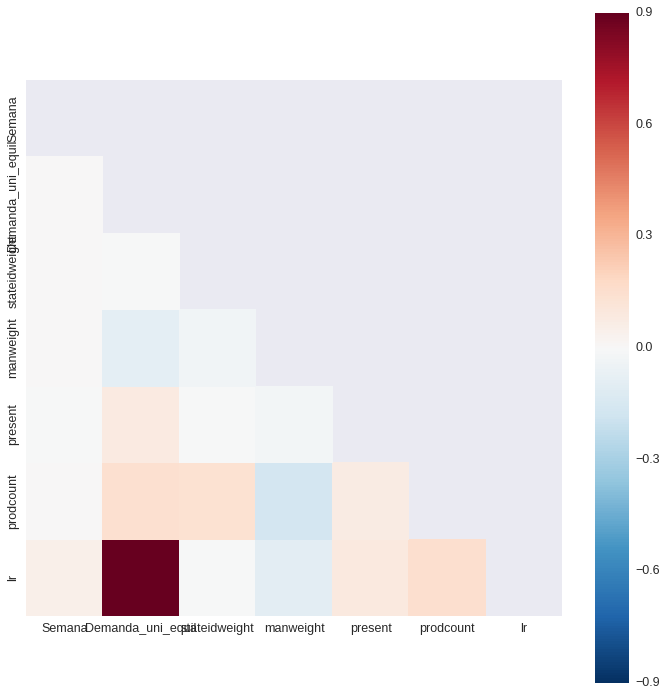

In [13]:
sns.set(font_scale=1.25)
f,ax = plt.subplots(1,1,figsize=(12,12))
_ = sns.heatmap(corr, mask=mask, vmax=0.9, square=True, ax=ax)

In [14]:
dftrain.to_csv(dataurl+'trainmod.csv', sep=',', index=False)

## Result

As expected, the linear regression is strongly correlated with demand. Also prodcount and name present have a small correlation. The size variable has a very weak correlation and so will be excluded from the final model for simplification purposes.

___
# Construct model

In [4]:
# drop size, stateidweight feature, make present feature integer
# dftrain.drop('size', axis=1, inplace=True)
# dftrain['present'] = dftrain['present'].astype(int)
# dftrain.drop('stateidweight', axis=1, inplace=True)

# Set aside data not to include in encoding
# dfcat = dftrain[['man', 'stateid']].astype(int).copy()
# y = dftrain['Demanda_uni_equil'].copy()
# dftrain.drop(['man', 'stateid', 'Demanda_uni_equil'], axis=1, inplace=True)
# dftrain.head()`

# load data if rerunning analysis
dftrain = pd.read_csv(dataurl+'trainmod.csv', 
                      usecols=['Semana', 'Demanda_uni_equil', 'manweight', 'present', 'prodcount', 'lr'])
dftrain.columns

Index(['Semana', 'Demanda_uni_equil', 'manweight', 'present', 'prodcount',
       'lr'],
      dtype='object')

In [4]:
# Use one hot encoding to convert categorical variables
# mask = [0,0,1,1,0,0,0]
# ohe = OneHotEncoder(categorical_features=mask, sparse=True)
# Xohe = ohe.fit_transform(dftrain)
# dfohe = pd.DataFrame(Xohe)

# append encoded and non-encoded data
# dftrain = pd.concat([dftrain,dfohe], axis=1, ignore_index=True)
# dftrain.head()

In [8]:
# divide into training and test sets
traincols = dftrain.columns.tolist()
ycol = 'Demanda_uni_equil'
traincols.remove(ycol)
traincols.remove('Semana')

# trainmask = dftrain['Semana'].isin([3,4,5,6,7])
# testmask = dftrain['Semana'].isin([8,9])
# Xtrain = dftrain[traincols][trainmask]
# ytrain = dftrain[ycol][trainmask]
# Xtest = dftrain[traincols][testmask]
# ytest = dftrain[ycol][testmask]

In [30]:
print('testlen: {0:,}  trainlen: {1:,}'.format(len(Xtrain), len(Xtest)))

testlen: 53,364,883  trainlen: 20,815,581


In [5]:
# make scoring function for RMLSE
# dir(metrics)
def rmsle(actual, predicted):
    return np.sqrt(np.mean(np.power(np.log(actual+1) - np.log(predicted+1), 2)))

scorermsle = make_scorer(rmsle, greater_is_better=False)

In [7]:
# standardize continuous features

ss = StandardScaler()

for col in ['manweight', 'prodcount', 'lr']:
    dftrain[col] = ss.fit_transform(dftrain[col].values.reshape(-1,1))

# reset/set values
trainmask = dftrain['Semana'].isin([3,4,5,6,7])
testmask = dftrain['Semana'].isin([8,9])
Xtrain = dftrain[traincols][trainmask]
ytrain = dftrain[ycol][trainmask]
Xtest = dftrain[traincols][testmask]
ytest = dftrain[ycol][testmask]

dftrain.head()

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Semana,Demanda_uni_equil,manweight,present,prodcount,lr
0,3,3,0.561661,1,-0.342426,-0.161926
1,3,4,0.561661,1,-0.342426,-0.239951
2,3,4,0.561661,1,-0.342426,-0.222848
3,3,4,0.561661,1,-0.342426,-0.067282
4,3,3,0.561661,1,-0.342426,-0.210463


In [8]:
# save standardized data

dftrain.to_csv(dataurl+'trainstd.csv', sep=',', index=False)

# Perform cross validation

In [3]:
# load standardized data
dftrain = pd.read_csv(dataurl+'trainstd.csv', 
                      usecols=['Semana', 'Demanda_uni_equil', 'manweight', 'present', 'prodcount', 'lr'])

NameError: name 'testmask' is not defined

In [48]:
# setup cv
ridgereg = Ridge()
alphas = {'alpha':[1,1e3,1e6]}
testmask = dftrain['Semana'].isin([8,9])
testfold = testmask * -1
cvmask = PredefinedSplit(testfold.tolist())

gridreg = GridSearchCV(ridgereg, alphas, scoring=scorermsle, n_jobs=1, cv=cvmask)
gridreg

GridSearchCV(cv=sklearn.cross_validation.PredefinedSplit(test_fold=[ 0  0 ..., -1 -1]),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 1000.0, 1000000.0]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

In [49]:
# perform
gridreg.fit(dftrain[traincols], dftrain[ycol])
gridreg.grid_scores_

[mean: -0.95144, std: 0.00000, params: {'alpha': 1},
 mean: -0.95180, std: 0.00000, params: {'alpha': 1000.0},
 mean: -0.89773, std: 0.00000, params: {'alpha': 1000000.0}]

In [ ]:
trainmask = dftrain['Semana'].isin([3,4,5,6,7])
testmask = dftrain['Semana'].isin([8,9])
Xtrain = dftrain[traincols][trainmask]
ytrain = dftrain[ycol][trainmask]
Xtest = dftrain[traincols][testmask]
ytest = dftrain[ycol][testmask]

In [46]:
ridgereg = Ridge()
alphas = np.logspace(0,8,20)
errs = []
for alpha in alphas:
    ridgereg.set_params(alpha=alpha)
    ridgereg.fit(Xtrain, ytrain)
    err = rmsle(ytest, ridgereg.predict(Xtest))
    # print('alpha: {0:.1e}, rmsle: {1:.9f}'.format(alpha, err))
    errs.append(err)

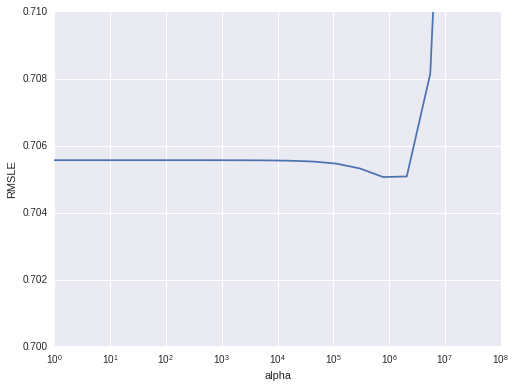

In [47]:
f = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
_ = plt.plot(alphas, errs)
ax.set_xscale('log')
ax.set_ylim(0.7,0.71)
ax.set_xlabel('alpha')
ax.set_ylabel('RMSLE')

In [50]:
# build final model

ridgereg.set_params(alpha=1e6)
ridgereg.fit(dftrain[traincols],dftrain[ycol])

Ridge(alpha=1000000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

## Result

Select regularization parameter of $\alpha = 10^{6}$.

___
# Load test data

In [54]:
dftest = inspectdata('test')
dftest.head()

(6999251, 7)
{'id': dtype('int64'), 'Cliente_ID': dtype('int64'), 'Ruta_SAK': dtype('int64'), 'Producto_ID': dtype('int64'), 'Semana': dtype('int64'), 'Agencia_ID': dtype('int64'), 'Canal_ID': dtype('int64')}


,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277


In [55]:
def valuecountrep(dftrain, col):
    # replace col with ranked list of valuecounts
    ser = dftrain[col].value_counts()
    rankweight = list(range(len(ser)))[::-1]
    serrank = pd.Series(rankweight)
    return pd.DataFrame({col:ser.index, col+'weight':serrank})

In [56]:
# global linear regression calculated previously semmean = [slope, intercept]
semmean = [8.4185166918455607, -54.842029041180105]

dfloc = pd.read_csv(dataurl+'statedict.csv', sep=',')
dftest = pd.merge(dftest, dfloc, how='left', on='Agencia_ID')
dftest['stateid'] = dftest['stateid'].astype(int)
dfstate = valuecountrep(dftest, 'stateid')
dftest = pd.merge(dftest, dfstate, how='left', on='stateid')
dftest.drop(['Agencia_ID','stateid'], axis=1, inplace=True)
dfloc = None
dfstate = None

dfprod = pd.read_csv(dataurl+'mandict.csv', sep=',')
dftest = pd.merge(dftest, dfprod, how='left', on='Producto_ID')
dftest['man'].fillna(dfprod['man'].value_counts().max(), inplace=True)
dftest['man'] = dftest['man'].astype(int)
dfman = valuecountrep(dftest, 'man')
dftest = pd.merge(dftest, dfman, how='left', on='man')
dftest.drop('man', axis=1, inplace=True)
# dftrain['size'].fillna(dfprod['size'].mean(), inplace=True)
dfprod = None
dfman = None

dfnamed = pd.read_csv(dataurl+'cliente_tabla_drop.csv', sep=',', usecols=['Cliente_ID', 'present'])
dftest = pd.merge(dftest, dfnamed, how='left', on='Cliente_ID')
dftest['present'].fillna(0, inplace=True)
dftest['present'] = dftest['present'].astype(int)
dfnamed = None

dfprodclient = pd.read_csv(dataurl+'producto_por_cliente.csv', sep=',')
dftest = pd.merge(dftest, dfprodclient, how='left', on='Cliente_ID')
dftest['prodcount'].fillna(dftest['prodcount'].value_counts().max(), inplace=True)
dfprodclient = None

dflr = pd.read_csv(dataurl+'linregress2.csv', sep=',')
dftest = pd.merge(dftest, dflr, how='left', on=['Producto_ID','Cliente_ID'])
dflr = None
dftest['slope'].fillna(semmean[0], inplace=True)
dftest['intercept'].fillna(semmean[1], inplace=True)
dftest['lr'] = dftest['slope'] * dftest['Semana'] + dftest['intercept']
dftest['lr'] = dftest['lr'].apply(lambda x: max(x,0))
dftest.drop(['Producto_ID', 'Cliente_ID', 'slope', 'intercept'], axis=1, inplace=True)

In [60]:
dftest.head()

,id,Semana,Canal_ID,Ruta_SAK,stateidweight,manweight,present,prodcount,lr
0,0,11,1,2209,23,25,0,12.0,37.761655
1,1,11,1,1226,11,26,0,21.0,37.761655
2,2,10,1,2831,25,25,0,14.0,2.000000
3,3,11,1,4448,32,25,0,56.0,37.761655
4,4,11,1,1130,32,26,0,30.0,37.761655


In [65]:
print(len(dftest[dftest['prodcount'].isnull()]))
dftest['prodcount'].fillna(dftest['prodcount'].value_counts().max(), inplace=True)
print(len(dftest[dftest['prodcount'].isnull()]))

30054
0


In [67]:
dftest.head()

,id,Semana,manweight,present,prodcount,lr
0,0,11,-0.117217,0,12.0,37.761655
1,1,11,0.575472,0,21.0,37.761655
2,2,10,-0.117217,0,14.0,2.000000
3,3,11,-0.117217,0,56.0,37.761655
4,4,11,0.575472,0,30.0,37.761655


In [70]:
# drop unneeded columns
# dftest.drop(['Canal_ID', 'Ruta_SAK', 'stateidweight'], axis=1, inplace=True)

# standardize select columns
ss = StandardScaler()
for col in ['manweight', 'prodcount', 'lr']:
    dftest[col] = ss.fit_transform(dftest[col].values.reshape(-1,1))

# make prediction
cols=['manweight', 'present', 'prodcount', 'lr']
ypred = ridgereg.predict(dftest[cols])
dftest['Demanda_uni_equil'] = ypred
dftest['Demanda_uni_equil'] = dftest['Demanda_uni_equil'].apply(lambda x: max(x,0))

# save prediction
nowpt = datetime.datetime.now()
nowstr = nowpt.strftime('%Y%m%d_%H%M')
dftest[['id','Demanda_uni_equil']].to_csv(dataurl+'mloutput'+nowstr+'.csv', sep=',', index=False)

In [71]:
# ypred[:10]
len(ypred)

6999251